In [1]:
import numpy as np
import pandas as pd
import re
import pydot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os.path
from os import path

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

from sklearn.metrics import precision_score, recall_score
from sklearn import svm
from sklearn.metrics import accuracy_score


In [2]:
df_train = pd.read_csv('../input/train.csv');
df_test = pd.read_csv('../input/test.csv')
entiredata = [df_train, df_test]
originaltraindata = df_train.copy()
PassengerId  = df_test['PassengerId']
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",male,347082,B96 B98,S
freq,1,577,7,4,644


In [5]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


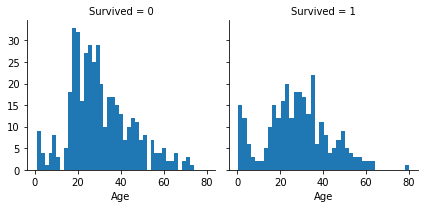

In [7]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=40)

C:\Users\priya\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


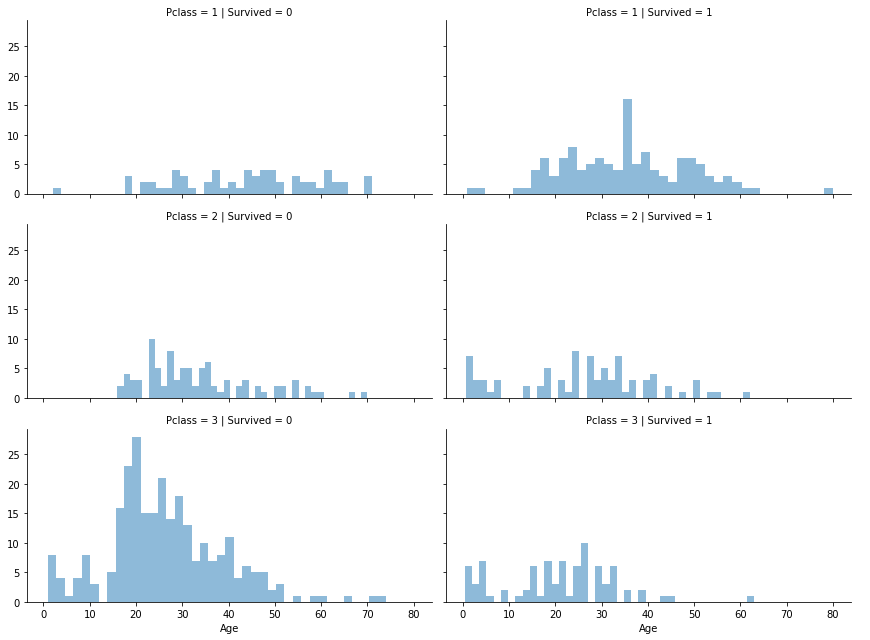

In [8]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=3, aspect=2)
grid.map(plt.hist, 'Age', alpha=.5, bins=40)
grid.add_legend();

C:\Users\priya\anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


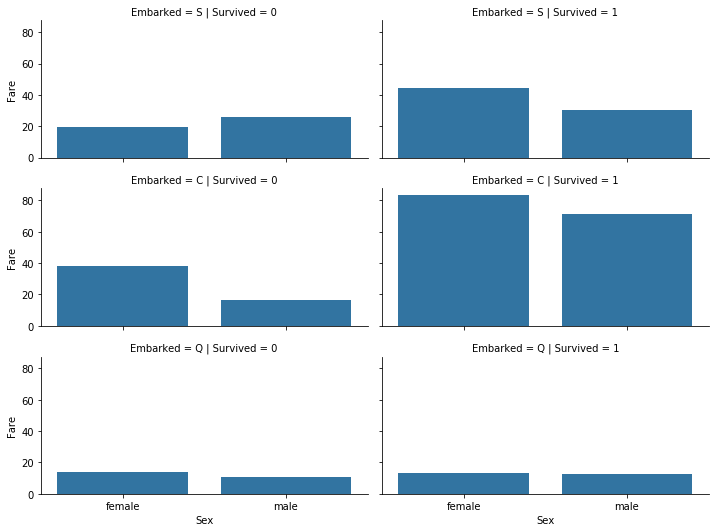

In [9]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.5, aspect=2)
grid.map(sns.barplot, 'Sex', 'Fare', ci=None)
grid.add_legend()

In [10]:
#creating a new feature family and isalone
for data in entiredata:
    data['family'] = data['SibSp'] + data['Parch'] 

for data in entiredata:
    data['isalone'] = 0
    data.loc[data['family'] == 0, 'isalone'] = 1
df_train.head()
    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [11]:
# Adding titles
def title(name):
    search_title = re.search(' ([A-Za-z]+)\.', name)
    # etract the title if exists and return
    if search_title:
        return search_title.group(1)
    return ""

for data in entiredata:
    data['Title'] = data['Name'].apply(title)
for data in entiredata:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')


In [12]:
# mapping titles
for data in entiredata:
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)

In [13]:
#missing details 
missing_train = df_train.isnull().sum()
missing_test = df_test.isnull().sum()
missing_test


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
family           0
isalone          0
Title            0
dtype: int64

In [14]:
missing_train

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
family           0
isalone          0
Title            0
dtype: int64

In [15]:
# Removing Nulls from Embarked, fare
for data in entiredata:
    data['Embarked'] = data['Embarked'].fillna(df_train.Embarked.dropna().mode()[0])
for data in entiredata:
    data['Fare'] = data['Fare'].fillna(df_train['Fare'].median())

In [16]:
# mapping gender female:1 male:0
for data in entiredata:
    data['Sex'] = data['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [17]:
#Removing nulls from age
pred_ages = np.zeros((2,3))
pred_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [18]:
for data in entiredata:
    for i in range(0, 2):
        for j in range(0, 3):
            pred_df = data[(data['Sex'] == i) & \
                                  (data['Pclass'] == j+1)]['Age'].dropna()
            age_pred = pred_df.median()
            pred_ages[i,j] = int( age_pred/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            data.loc[ (data.Age.isnull()) & (data.Sex == i) & (data.Pclass == j+1),\
                    'Age'] = pred_ages[i,j]

    data['Age'] = data['Age'].astype(int)

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,isalone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C,1,0,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,S,1,0,3
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,S,0,1,1


In [19]:
# Mapping Age, fare , Embarked
for data in entiredata:
    data.loc[ data['Age'] <= 16, 'Age']    = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4
    
    data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
    data.loc[ data['Fare'] > 31, 'Fare'] = 3
    data['Fare'] = data['Fare'].astype(int)
    
    data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [20]:
# Feature Selection : Removing irrelavant features
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_train = df_train.drop(drop_features, axis = 1)
df_test = df_test.drop(drop_features, axis = 1)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family,isalone,Title
0,0,3,0,1,1,0,0,0,1,0,1
1,1,1,1,2,1,0,3,1,1,0,3
2,1,3,1,1,0,0,1,0,0,1,4
3,1,1,1,2,1,0,3,0,1,0,3
4,0,3,0,2,0,0,1,0,0,1,1


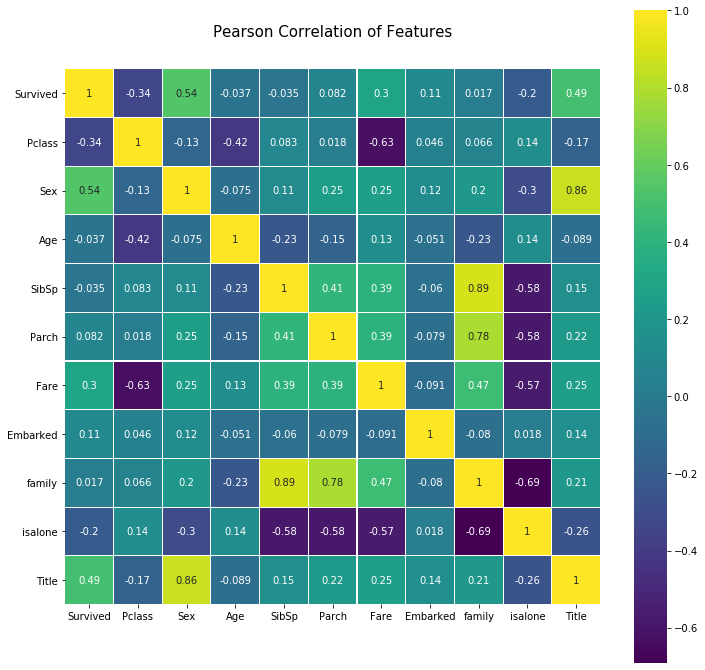

In [21]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_train.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [22]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family,isalone,Title
0,0,3,0,1,1,0,0,0,1,0,1
1,1,1,1,2,1,0,3,1,1,0,3
2,1,3,1,1,0,0,1,0,0,1,4
3,1,1,1,2,1,0,3,0,1,0,3
4,0,3,0,2,0,0,1,0,0,1,1


In [23]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family,isalone,Title
0,3,0,2,0,0,0,2,0,1,1
1,3,1,2,1,0,0,0,1,0,3
2,2,0,3,0,0,1,2,0,1,1
3,3,0,1,0,0,1,0,0,1,1
4,3,1,1,1,1,1,0,2,0,3


In [26]:
# 5 fold cross validation 
y_train = df_train['Survived']
x_train = df_train.drop(['Survived'], axis=1).values 
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.79 (+/- 0.04)


In [27]:
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.03)


In [29]:
clf = svm.SVC(kernel='poly', C=1)
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f) " % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.03) 
